
# GOOGLE PLAY STORE — APPS & REVIEWS ANALYSIS

The Google Play Store is the largest Android app marketplace, hosting millions of apps across diverse categories.  
Understanding this ecosystem is critical for both developers and analysts who want to explore market opportunities, user behavior, and monetization strategies.

In this notebook, we analyze a dataset of **apps and reviews scraped from the Play Store**. The analysis includes:
- Cleaning and transforming raw data (installs, prices, sizes)  
- Identifying duplicates and handling missing values  
- Exploring app ratings, installs, and size distributions  
- Comparing free vs. paid apps, and reviewing revenue implications  
- Visualizing category patterns using **Plotly**  

This project provides insights into the **structure of the app economy**, the **distribution of downloads**, and the **business dynamics** of app development.


## Import Statements

In [1]:

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio

pd.options.display.float_format = '{:,.2f}'.format


## Make Plotly render as static images (so GitHub shows them)

In [2]:

# We try to use a static image renderer so the figures are embedded in the notebook outputs.
# If 'kaleido' is missing, we'll fall back to writing PNGs and displaying them.
from IPython.display import Image, display

def _try_set_png_renderer():
    try:
        # This uses kaleido under the hood. If not installed, fig.show() will fail and we'll handle it.
        pio.renderers.default = "png"
        return True
    except Exception:
        return False

_png_renderer_ok = _try_set_png_renderer()

def show_plotly(fig, name="figure"):
    """
    Shows a Plotly figure as a static PNG so GitHub can render it.
    1) Tries fig.show() with 'png' renderer.
    2) If that fails (e.g., kaleido not installed), writes a PNG then displays it.
    3) If that also fails, prints a helpful message.
    """
    try:
        fig.show()
        return
    except Exception:
        pass  # Try writing out a PNG instead.

    # Fallback: write PNG file and display it inline
    png_path = f"{name}.png"
    try:
        fig.write_image(png_path)
        display(Image(filename=png_path))
    except Exception as e:
        print(
            "Unable to render static Plotly image.\n"
            "Please install kaleido with: pip install -U kaleido\n"
            f"Details: {e}"
        )


## Read the Dataset

In [3]:

df_apps = pd.read_csv('apps.csv')
df_apps.head()


,App,Category,Rating,Reviews,Size_MBs,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Android_Ver
0,Ak Parti Yardım Toplama,SOCIAL,NaN,0,8.70,0,Paid,$13.99,Teen,Social,"July 28, 2017",4.1 and up
1,Ain Arabic Kids Alif Ba ta,FAMILY,NaN,0,33.00,0,Paid,$2.99,Everyone,Education,"April 15, 2016",3.0 and up
2,Popsicle Launcher for Android P 9.0 launcher,PERSONALIZATION,NaN,0,5.50,0,Paid,$1.49,Everyone,Personalization,"July 11, 2018",4.2 and up
3,Command & Conquer: Rivals,FAMILY,NaN,0,19.00,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device
4,CX Network,BUSINESS,NaN,0,10.00,0,Free,0,Everyone,Business,"August 6, 2018",4.1 and up


## Standardize Column Names

In [4]:

df_apps.columns = (
    df_apps.columns
      .str.strip()
      .str.replace(' ', '_')
      .str.replace('[^0-9a-zA-Z_]', '', regex=True)
)
print(df_apps.columns.tolist())


['App', 'Category', 'Rating', 'Reviews', 'Size_MBs', 'Installs', 'Type', 'Price', 'Content_Rating', 'Genres', 'Last_Updated', 'Android_Ver']


## Drop Unused Columns

In [5]:

df_apps = df_apps.drop(columns=['Last_Updated','Android_Version'], errors='ignore')
df_apps.head()


,App,Category,Rating,Reviews,Size_MBs,Installs,Type,Price,Content_Rating,Genres,Android_Ver
0,Ak Parti Yardım Toplama,SOCIAL,NaN,0,8.70,0,Paid,$13.99,Teen,Social,4.1 and up
1,Ain Arabic Kids Alif Ba ta,FAMILY,NaN,0,33.00,0,Paid,$2.99,Everyone,Education,3.0 and up
2,Popsicle Launcher for Android P 9.0 launcher,PERSONALIZATION,NaN,0,5.50,0,Paid,$1.49,Everyone,Personalization,4.2 and up
3,Command & Conquer: Rivals,FAMILY,NaN,0,19.00,0,NaN,0,Everyone 10+,Strategy,Varies with device
4,CX Network,BUSINESS,NaN,0,10.00,0,Free,0,Everyone,Business,4.1 and up


## Parse Size to MB

In [6]:

def parse_size_mb(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.lower().startswith('varies'):
        return np.nan
    last = s[-1:].lower()
    try:
        if last == 'k':
            return float(s[:-1]) / 1024.0
        if last == 'm':
            return float(s[:-1])
        if last == 'g':
            return float(s[:-1]) * 1024.0
        return float(s)
    except:
        return np.nan

if 'Size' in df_apps.columns:
    df_apps['Size_MBs'] = df_apps['Size'].apply(parse_size_mb)

df_apps[['Size','Size_MBs']].head() if 'Size' in df_apps.columns else df_apps.head()


,App,Category,Rating,Reviews,Size_MBs,Installs,Type,Price,Content_Rating,Genres,Android_Ver
0,Ak Parti Yardım Toplama,SOCIAL,NaN,0,8.70,0,Paid,$13.99,Teen,Social,4.1 and up
1,Ain Arabic Kids Alif Ba ta,FAMILY,NaN,0,33.00,0,Paid,$2.99,Everyone,Education,3.0 and up
2,Popsicle Launcher for Android P 9.0 launcher,PERSONALIZATION,NaN,0,5.50,0,Paid,$1.49,Everyone,Personalization,4.2 and up
3,Command & Conquer: Rivals,FAMILY,NaN,0,19.00,0,NaN,0,Everyone 10+,Strategy,Varies with device
4,CX Network,BUSINESS,NaN,0,10.00,0,Free,0,Everyone,Business,4.1 and up


## Clean Installs and Price

In [7]:

if 'Installs' in df_apps.columns:
    df_apps['Installs'] = (
        df_apps['Installs'].astype(str)
        .str.replace(',', '', regex=False)
        .str.replace('+', '', regex=False)
    )
    df_apps['Installs'] = pd.to_numeric(df_apps['Installs'], errors='coerce')

if 'Price' in df_apps.columns:
    df_apps['Price'] = df_apps['Price'].astype(str).str.replace('$','', regex=False)
    df_apps['Price'] = pd.to_numeric(df_apps['Price'], errors='coerce')

if 'Rating' in df_apps.columns:
    df_apps['Rating'] = pd.to_numeric(df_apps['Rating'], errors='coerce')

if 'Reviews' in df_apps.columns:
    df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'], errors='coerce')

df_apps.head()


,App,Category,Rating,Reviews,Size_MBs,Installs,Type,Price,Content_Rating,Genres,Android_Ver
0,Ak Parti Yardım Toplama,SOCIAL,NaN,0,8.70,0,Paid,13.99,Teen,Social,4.1 and up
1,Ain Arabic Kids Alif Ba ta,FAMILY,NaN,0,33.00,0,Paid,2.99,Everyone,Education,3.0 and up
2,Popsicle Launcher for Android P 9.0 launcher,PERSONALIZATION,NaN,0,5.50,0,Paid,1.49,Everyone,Personalization,4.2 and up
3,Command & Conquer: Rivals,FAMILY,NaN,0,19.00,0,NaN,0.00,Everyone 10+,Strategy,Varies with device
4,CX Network,BUSINESS,NaN,0,10.00,0,Free,0.00,Everyone,Business,4.1 and up


## Remove Missing Values

In [8]:

key_cols = [c for c in ['App','Category','Type','Price','Installs','Rating'] if c in df_apps.columns]
df_apps_clean = df_apps.dropna(subset=key_cols).copy()
print('Rows after cleaning:', len(df_apps_clean))


Rows after cleaning: 9367


## Remove Duplicates

In [9]:

subset_cols = [c for c in ['App','Type','Price'] if c in df_apps_clean.columns]
df_apps_clean = df_apps_clean.drop_duplicates(subset=subset_cols, keep='first')
print('Rows after deduplication:', len(df_apps_clean))


Rows after deduplication: 8199


## Quick Views

In [10]:

print('Top by Installs:')
print(df_apps_clean.sort_values('Installs', ascending=False).head(10)[['App','Category','Installs']])


Top by Installs:
                                            App             Category  \
10784  Messenger – Text and Video Chat for Free        COMMUNICATION   
10822                                    Google                TOOLS   
10803                         Google Play Games        ENTERTAINMENT   
10792             Skype - free IM & video calls        COMMUNICATION   
10788                                  Hangouts        COMMUNICATION   
10787                                     Gmail        COMMUNICATION   
10786              Google Chrome: Fast & Secure        COMMUNICATION   
10828                                   YouTube        VIDEO_PLAYERS   
10783                         Google Play Books  BOOKS_AND_REFERENCE   
10785                        WhatsApp Messenger        COMMUNICATION   

         Installs  
10784  1000000000  
10822  1000000000  
10803  1000000000  
10792  1000000000  
10788  1000000000  
10787  1000000000  
10786  1000000000  
10828  1000000000  
10783  100

In [11]:

print('\nTop by Rating (>= 1000 reviews):')
if 'Reviews' in df_apps_clean.columns:
    filt = df_apps_clean['Reviews'] >= 1000
    top_rate = df_apps_clean.loc[filt].sort_values(['Rating','Reviews'], ascending=[False, False]).head(10)
    cols = [c for c in ['App','Category','Rating','Reviews'] if c in top_rate.columns]
    print(top_rate[cols])
else:
    print(df_apps_clean.sort_values('Rating', ascending=False).head(10)[['App','Category','Rating']])



Top by Rating (>= 1000 reviews):
                                                    App             Category  \
9029                                         JW Library  BOOKS_AND_REFERENCE   
9599                  Six Pack in 30 Days - Abs Workout   HEALTH_AND_FITNESS   
7320                            Tickets + PDA 2018 Exam    AUTO_AND_VEHICLES   
7149     Learn Japanese, Korean, Chinese Offline & Free            EDUCATION   
7174                                     Period Tracker              MEDICAL   
7127  StrongLifts 5x5 Workout Gym Log & Personal Tra...   HEALTH_AND_FITNESS   
6484  PixPanda - Color by Number Pixel Art Coloring ...               FAMILY   
6476                     ipsy: Makeup, Beauty, and Tips               BEAUTY   
6125  Hungry Hearts Diner: A Tale of Star-Crossed Souls               FAMILY   
8168           Lose Belly Fat in 30 Days - Flat Stomach   HEALTH_AND_FITNESS   

      Rating  Reviews  
9029    4.90   922752  
9599    4.90   272337  
7320    4.90 

## Plotly Visualizations (rendered as static images for GitHub)

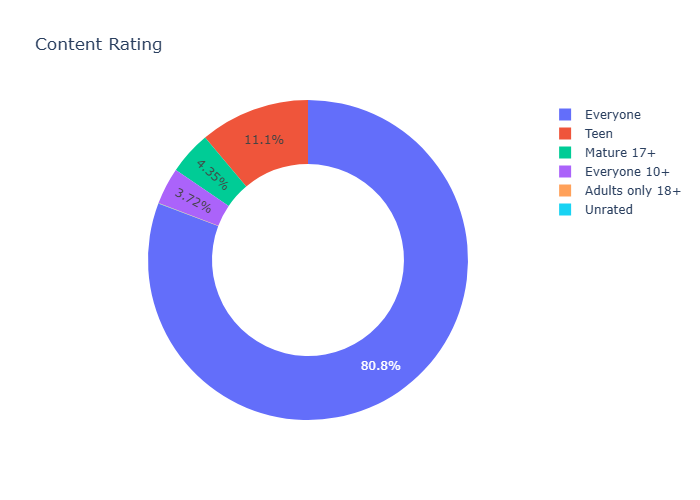

In [12]:

if 'Content_Rating' in df_apps_clean.columns:
    cr = df_apps_clean['Content_Rating'].value_counts()
    fig = px.pie(
        labels=cr.index, values=cr.values, names=cr.index,
        title='Content Rating', hole=0.6
    )
    fig.update_traces(textposition='inside', textinfo='percent')
    show_plotly(fig, name="content_rating")


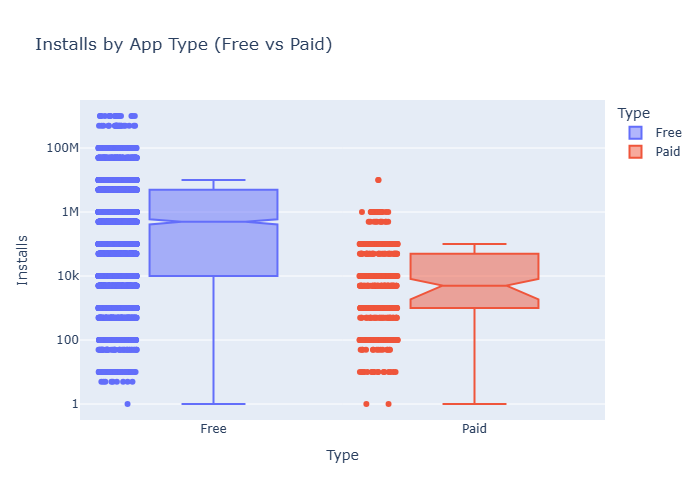

In [13]:

if set(['Type','Installs']).issubset(df_apps_clean.columns):
    fig = px.box(
        df_apps_clean, y='Installs', x='Type', color='Type', notched=True, points='all',
        title='Installs by App Type (Free vs Paid)'
    )
    fig.update_layout(yaxis=dict(type='log'))
    show_plotly(fig, name="installs_by_type")



## Conclusion

- **High ratings alone are misleading**: many apps have great ratings but very few reviews.  
- **App size & complexity**: sizes range from kilobytes to hundreds of MBs, with games and multimedia generally larger.  
- **Installations are unevenly distributed**: only a few apps pass the 1B+ installs mark.  
- **Paid apps**: most are under $10; few are priced higher.  
- **Revenue**: a handful of categories dominate downloads and monetization.  
- **Free vs Paid**: free apps dominate volume and downloads; paid apps trade reach for revenue.  

The Play Store follows a **winner-takes-most dynamic**, with a few apps capturing most of the installs and revenue. Developers should consider **category, pricing, and competition** when launching new apps.
